In [ ]:
#libraries
library(ArchR)
library(dplyr)
library(tidyr)
library(ggplot2)
library(argparse)
library(pheatmap)
library(rGREAT)
library("FactoMineR")
library(factoextra)

#path
SEED <- 123
set.seed(SEED)
datetime <- paste(Sys.Date(), Sys.time(), sep = "_")

#functions scripts
source_all_r_files <- function(path_list){
    origin_wd = getwd()
    lapply(
        path_list, function(x) {
            setwd(x)
            file.sources = list.files(pattern =  "*.r$")
            sapply(file.sources,source,.GlobalEnv)
        }
    )
    setwd(origin_wd)
}
source_all_r_files(#TOCHANGE)
check_a_path(OUT_PEAKS)
#set up
addArchRThreads(ceiling(parallelly::availableCores()/2))
addArchRGenome("hg38")
addArchRLocking(locking = T)

# Astrocytoma treated vs not 

In [2]:
analysis_name <- "Astrocytoma treated vs not"

In [3]:
sample_annotation_df <- read.csv(#TOCHANGE)

In [4]:
# import results 
results_import <- readRDS(#TOCHANGE)
results_genes <- readRDS(#TOCHANGE)
peak_set <- readRDS(#TOCHANGE)

In [5]:
full_mat_scaled_list <- lapply(results_import$matrices, function(i) {a <- scale(t(i))
                                                                             print("done")
                                                                             return(a)})
names(full_mat_scaled_list) <- names(results_import$matrices)

[1] "done"
[1] "done"
[1] "done"


In [6]:
se_list_astro_both <- lapply(colnames(results_import$Peaks), function(col) {
    list(Peaks = results_import$Peaks[,col], MotifsUp = results_import$MotifsUp[,col], MotifsDown = results_import$MotifsDown[,col], 
         Genes = NULL)#results_genes_astro$results[results_genes_astro$results$cell_type == col,])
})
names(se_list_astro_both) <- colnames(results_import$Peaks)

motifs_up_astro_df  <- lapply(names(se_list_astro_both), function(name) getDFfromSESample(se_list_astro_both[[name]]$MotifsUp))
names(motifs_up_astro_df) <- names(se_list_astro_both)
motifs_down_astro_df  <- lapply(names(se_list_astro_both), function(name) getDFfromSESample(se_list_astro_both[[name]]$MotifsDown))
names(motifs_down_astro_df) <- names(se_list_astro_both)

# Undifferentiated

## DAR

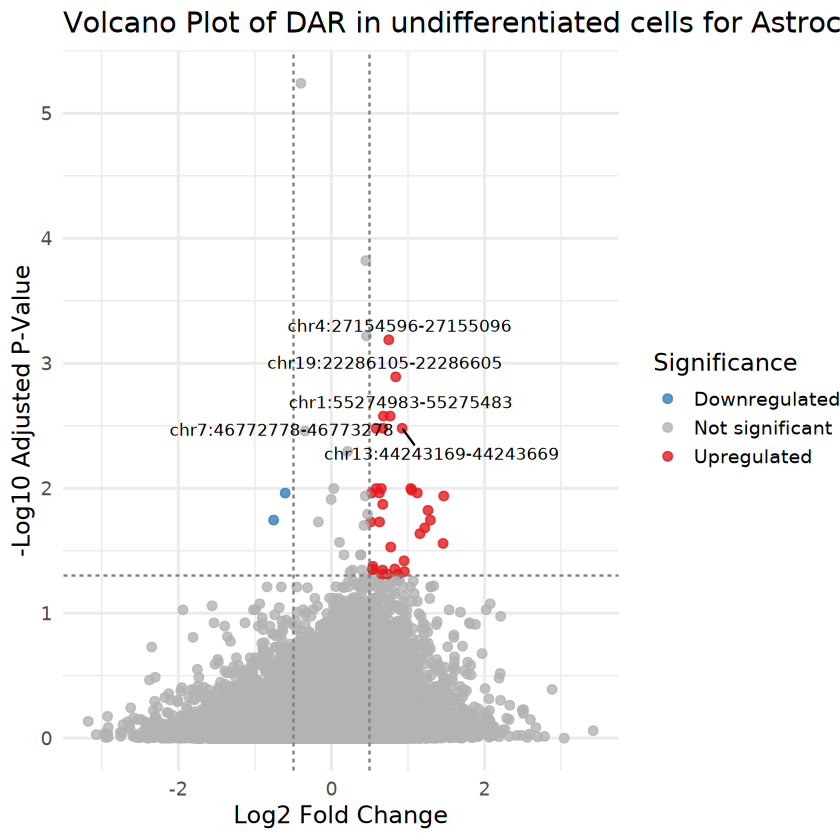

In [154]:
# plot volcano libra 
cell.type <- "undifferentiated"
plotVolcanoLibra(results_import$Libra[results_import$Libra$cell_type == cell.type, ], logfc_col = "avg_logFC", pval_col = "p_val_adj",
                         label_col = "gene", title = paste("Volcano Plot of DAR in", cell.type, "cells for", analysis_name),
                         logfc_thresh = 0.5, pval_thresh = 0.05)

In [155]:
sig_variables <- results_import$Libra %>%
  filter(cell_type == cell.type, p_val_adj < 0.05, abs(avg_logFC) > 0.5) %>%
  pull(gene)
sig_regions_undiff = sig_variables

Bootstrap (r = 0.5)... Done.
Bootstrap (r = 0.58)... Done.
Bootstrap (r = 0.69)... Done.
Bootstrap (r = 0.78)... Done.
Bootstrap (r = 0.89)... Done.
Bootstrap (r = 1.0)... Done.
Bootstrap (r = 1.08)... Done.
Bootstrap (r = 1.19)... Done.
Bootstrap (r = 1.28)... Done.
Bootstrap (r = 1.39)... Done.


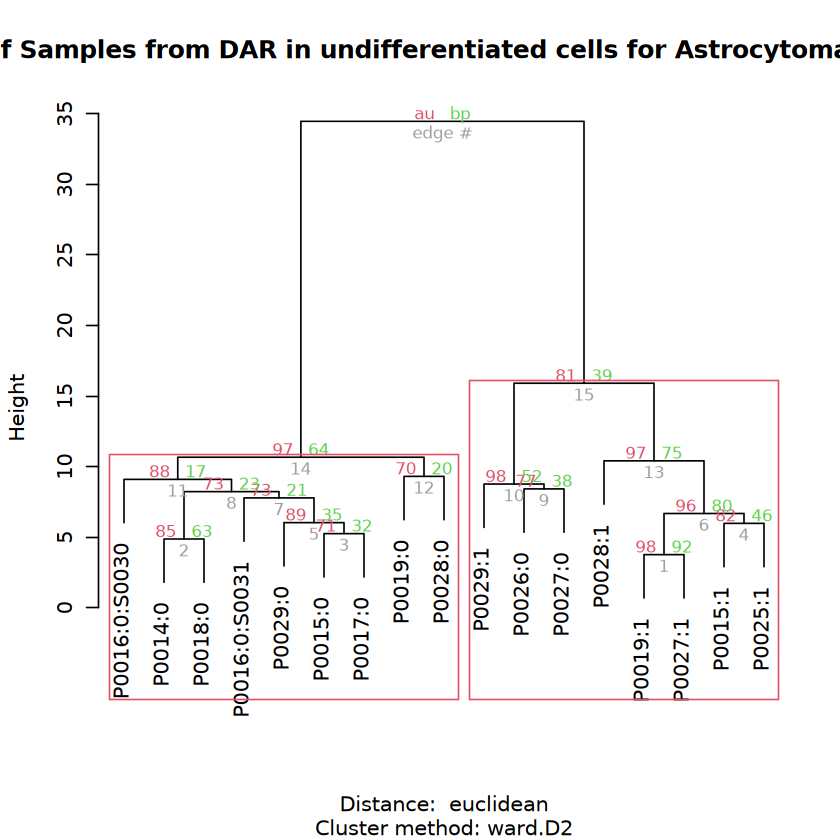

In [23]:
# Extract significant genes
library(pvclust)
sig_variables <- results_import$Libra %>%
  filter(cell_type == cell.type, p_val_adj < 0.05, abs(avg_logFC) > 0.5) %>%
  pull(gene)

# Subset matrix for significant genes
mat <- t(results_import$matrices[[cell.type]][sig_variables, ])
log_mat <- log1p(mat)

# Perform pvclust bootstrapped clustering on samples (columns)
# Transpose is needed: rows = samples, columns = genes
pv_result <- pvclust(t(log_mat), method.hclust = "ward.D2", method.dist = "euclidean", nboot = 10000)

# Plot dendrogram with bootstrap values
plot(pv_result, main = paste("Clustering of Samples from DAR in", cell.type, "cells for", analysis_name))
pvrect(pv_result, alpha = 0.8) 

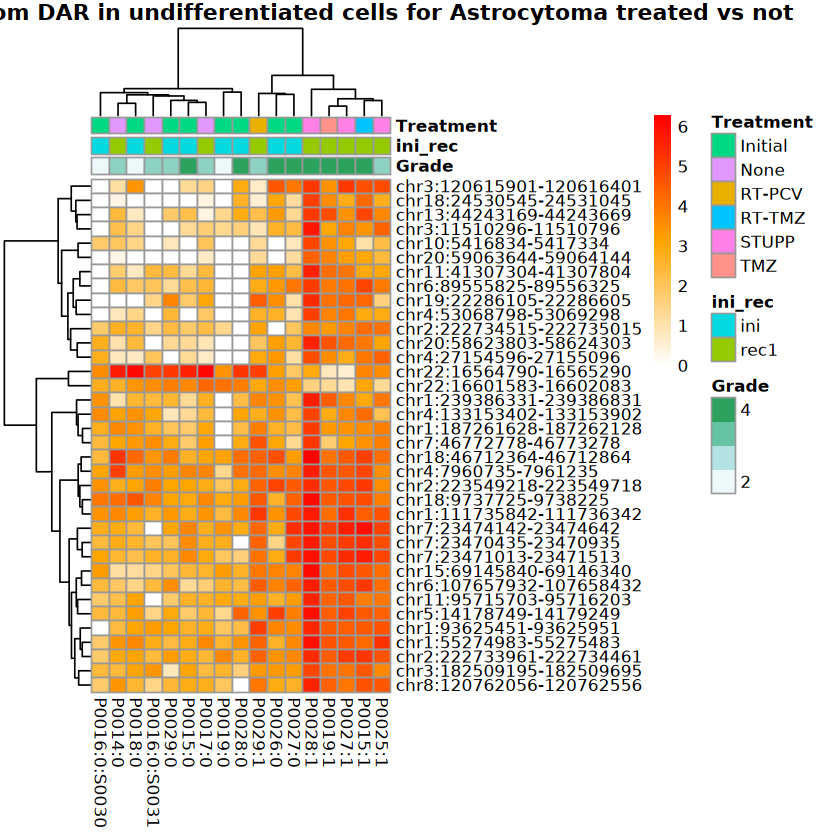

In [24]:
sig_variables <- results_import$Libra %>% filter(cell_type == cell.type & p_val_adj < 0.05 & abs(avg_logFC) > 0.5) %>% pull(name = "gene")
mat <- t(results_import$matrices[[cell.type]][names(sig_variables),])

p <- pheatmap(log1p(t(mat)), clustering_method = "ward.D2", annotation_col = sample_annotation_df[,c("Grade", "ini_rec", "Treatment")], 
             color = colorRampPalette(c("white", "orange", "red"))(100), cluster_col = pv_result$hclust, main = paste("Clustering of Samples from DAR in", cell.type, "cells for", analysis_name))

## PCA

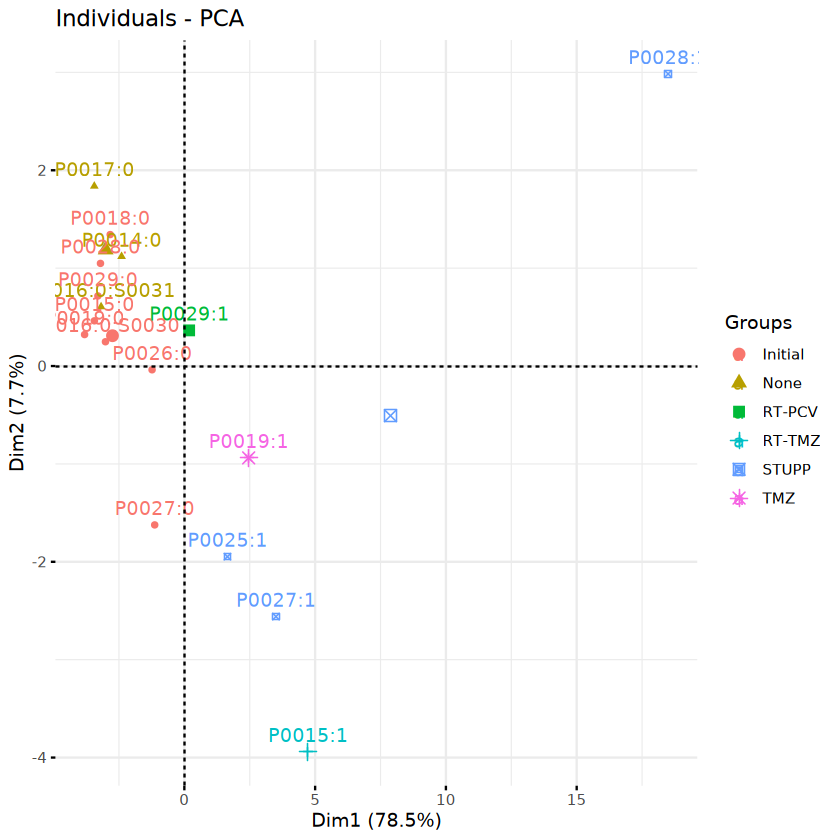

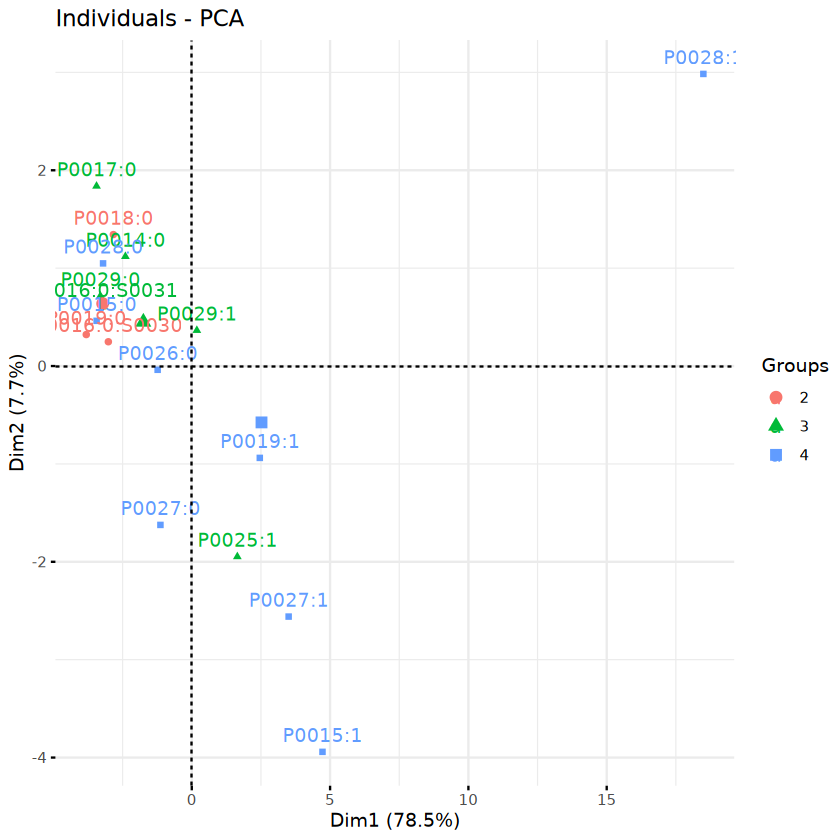

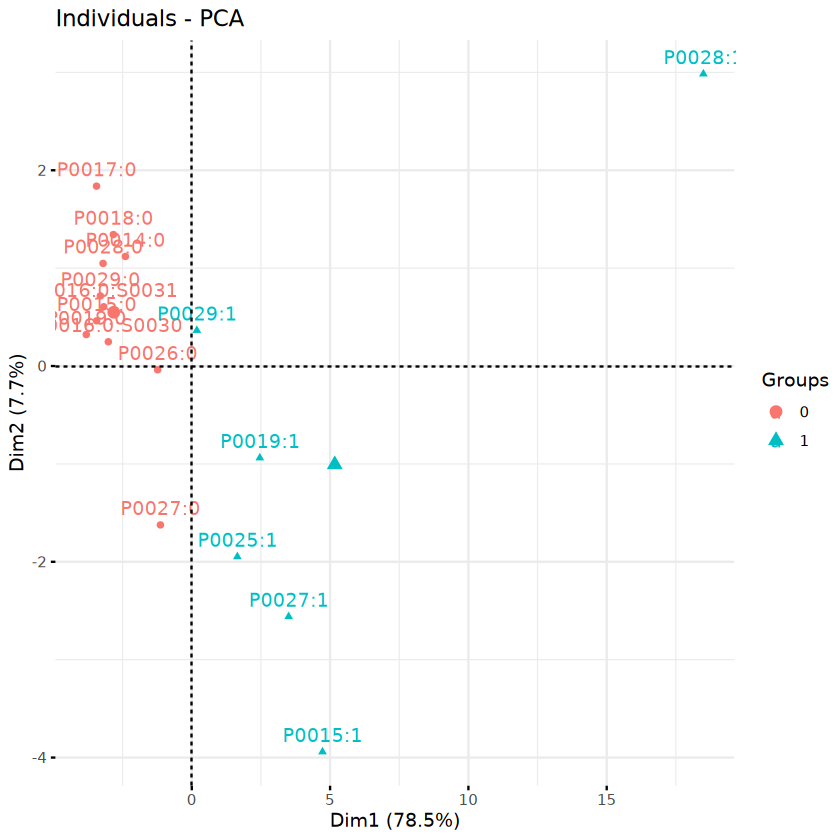

In [25]:
cell.type = "undifferentiated"
sig_variables <- results_import$Libra %>% filter(cell_type == cell.type & p_val_adj < 0.05 & abs(avg_logFC) > 0.5) %>% pull(gene)
filtered_mat <- full_mat_scaled_list[[cell.type]][,sig_variables]
res.pca.scaled <- PCA(
  filtered_mat,
  graph = FALSE
)
fviz_pca_ind(res.pca.scaled, habillage = factor(sample_annotation_df[rownames(full_mat_scaled_list[[cell.type]]),"Treatment"]))

fviz_pca_ind(res.pca.scaled, habillage = factor(sample_annotation_df[rownames(full_mat_scaled_list[[cell.type]]),"Grade"]))
fviz_pca_ind(res.pca.scaled, habillage = factor(sample_annotation_df[rownames(full_mat_scaled_list[[cell.type]]),"neo_adjuvant"]))

## Motifs 

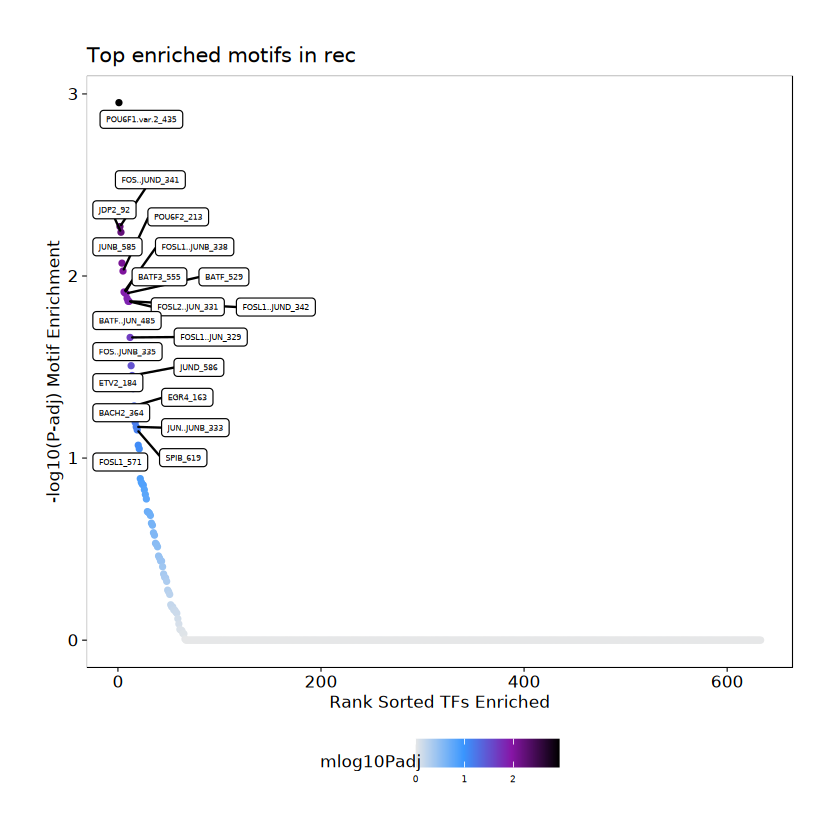

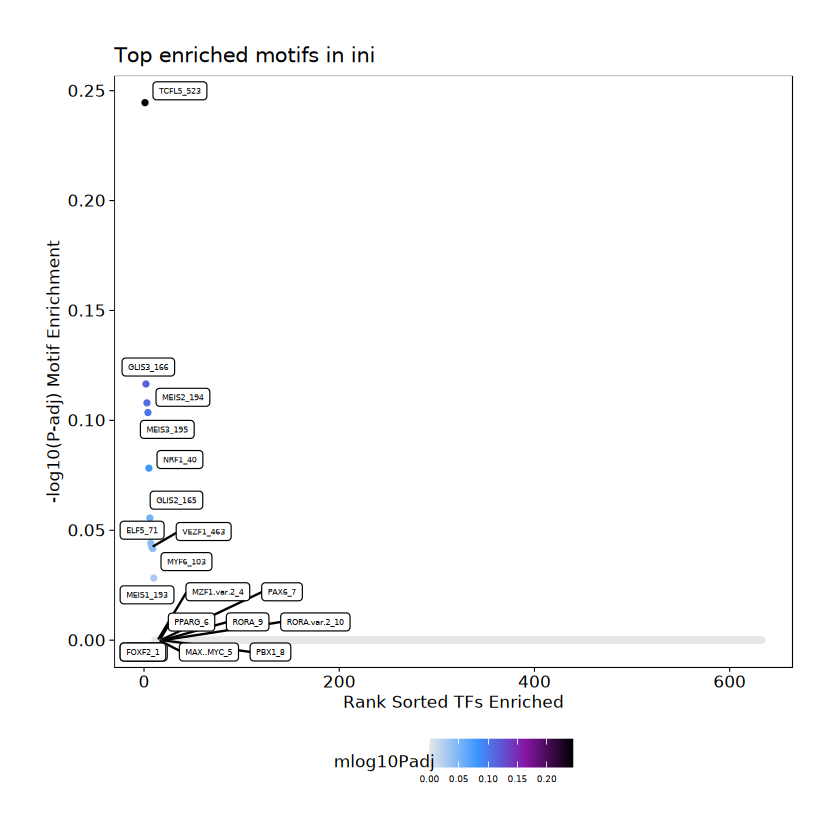

In [135]:
cell.type = "undifferentiated"
plotTopDiffMotifs(results_import$MotifsUp[, cell.type], name = "rec")
plotTopDiffMotifs(results_import$MotifsDown[, cell.type], name = "ini")

In [152]:
cell.type = "undifferentiated"
motifs_up_astro_df[[cell.type]] %>% arrange(desc(mlog10Padj)) %>% filter(mlog10Padj > 1.301)

,mlog10Padj,mlog10p,Enrichment,BackgroundProporition,nBackground,BackgroundFrequency,CompareProportion,nCompare,CompareFrequency,feature
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<chr>
POU6F1.var.2_435,2.952057,3.9063,5.113043,0.04601841,304552,14015,0.2352941,34,8,POU6F1.var.2_435
FOS..JUND_341,2.271457,3.2257,3.607980,0.07336678,304552,22344,0.2647059,34,9,FOS..JUND_341
JDP2_92,2.240357,3.1946,4.012503,0.05864023,304552,17859,0.2352941,34,8,JDP2_92
JUNB_585,2.070557,3.0248,3.780296,0.06224224,304552,18956,0.2352941,34,8,JUNB_585
POU6F2_213,2.027357,2.9816,4.259639,0.04833329,304552,14720,0.2058824,34,7,POU6F2_213
FOSL1..JUNB_338,1.912257,2.8665,3.573139,0.06585082,304552,20055,0.2352941,34,8,FOSL1..JUNB_338
BATF3_555,1.906457,2.8607,3.208370,0.08250479,304552,25127,0.2647059,34,9,BATF3_555
BATF_529,1.903957,2.8582,3.205818,0.08257046,304552,25147,0.2647059,34,9,BATF_529
BATF..JUN_485,1.877057,2.8313,3.177639,0.08330269,304552,25370,0.2647059,34,9,BATF..JUN_485


In [153]:
motifs_down_astro_df[[cell.type]] %>% arrange(desc(mlog10Padj)) %>% head(n = 10)

,mlog10Padj,mlog10p,Enrichment,BackgroundProporition,nBackground,BackgroundFrequency,CompareProportion,nCompare,CompareFrequency,feature
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<chr>
TCFL5_523,0.24455749,1.1988,15.552650,0.03214886,304552,9791,0.5,2,1,TCFL5_523
GLIS3_166,0.11655749,1.0708,11.514253,0.04342444,304552,13225,0.5,2,1,GLIS3_166
MEIS2_194,0.10795749,1.0622,11.283047,0.04431427,304552,13496,0.5,2,1,MEIS2_194
MEIS3_195,0.10355749,1.0578,11.168023,0.04477068,304552,13635,0.5,2,1,MEIS3_195
NRF1_40,0.07825749,1.0325,10.519931,0.04752883,304552,14475,0.5,2,1,NRF1_40
GLIS2_165,0.05555749,1.0098,9.970927,0.05014579,304552,15272,0.5,2,1,GLIS2_165
ELF5_71,0.04405749,0.9983,9.704053,0.05152486,304552,15692,0.5,2,1,ELF5_71
VEZF1_463,0.04235749,0.9966,9.665249,0.05173172,304552,15755,0.5,2,1,VEZF1_463
MYF6_103,0.04165749,0.9959,9.649325,0.05181710,304552,15781,0.5,2,1,MYF6_103


## Great Enrichment Analysis

In [ ]:
cell.type = "undifferentiated"
se_up <- se_lib[assays(se_lib)$Log2FC[,cell.type] > 0.5 & assays(se_lib)$FDR[,cell.type] < 0.05 & assays(se_lib)$Sig[,cell.type],]
se_down <- se_lib[assays(se_lib)$Log2FC[,cell.type] < -0.5 & assays(se_lib)$FDR[,cell.type] < 0.05 & assays(se_lib)$Sig[,cell.type],]
gr_up <- GenomicRanges::GRanges(
    seqnames = rowData(se_up)$seqnames,
    ranges = IRanges(start = rowData(se_up)$start, end = rowData(se_up)$end))
gr_down <- GenomicRanges::GRanges(
    seqnames = rowData(se_down)$seqnames,
    ranges = IRanges(start = rowData(se_down)$start, end = rowData(se_down)$end))
reduced_gr_up <- GenomicRanges::reduce(extendGR(gr_up, upstream = 1000, downstream = 1000))
reduced_gr_down <- GenomicRanges::reduce(extendGR(gr_down, upstream = 1000, downstream = 1000))


great_mf_up = great(reduced_gr_up, tss = "hg38", gene_sets = "GO:MF")
great_cc_up = great(reduced_gr_up, tss = "hg38", gene_sets = "GO:CC")
great_bp_up = great(reduced_gr_up, tss = "hg38", gene_sets = "GO:BP")
great_cancer_up = great(reduced_gr_up, tss = "hg38", gene_sets = "C4")
tbl_mf_up = getEnrichmentTables(great_mf_up)
tbl_cc_up = getEnrichmentTables(great_cc_up)
tbl_bp_up = getEnrichmentTables(great_bp_up)
tbl_cancer_up = getEnrichmentTables(great_cancer_up)
tbl_targets_up = getEnrichmentTables(great_targets_up)

great_mf_down = great(reduced_gr_down, tss = "hg38", gene_sets = "GO:MF")
great_cc_down = great(reduced_gr_down, tss = "hg38", gene_sets = "GO:CC")
great_bp_down = great(reduced_gr_down, tss = "hg38", gene_sets = "GO:BP")
great_cancer_down = great(reduced_gr_down, tss = "hg38", gene_sets = "C4")
tbl_mf_down = getEnrichmentTables(great_mf_down)
tbl_cc_down = getEnrichmentTables(great_cc_down)
tbl_bp_down = getEnrichmentTables(great_bp_down)
tbl_cancer_down = getEnrichmentTables(great_cancer_down)
tbl_targets_down = getEnrichmentTables(great_targets_down)

In [193]:
tbl_bp_up %>% filter(p_adjust < 0.05) %>% arrange(desc(fold_enrichment))

id,description,genome_fraction,observed_region_hits,fold_enrichment,p_value,p_adjust,mean_tss_dist,observed_gene_hits,gene_set_size,fold_enrichment_hyper,p_value_hyper,p_adjust_hyper
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>


In [194]:
tbl_bp_down %>% filter(p_adjust < 0.05) %>% arrange(desc(fold_enrichment))

id,description,genome_fraction,observed_region_hits,fold_enrichment,p_value,p_adjust,mean_tss_dist,observed_gene_hits,gene_set_size,fold_enrichment_hyper,p_value_hyper,p_adjust_hyper
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>


In [196]:
tbl_mf_up %>% filter(p_adjust < 0.05) %>% arrange(desc(fold_enrichment))

id,description,genome_fraction,observed_region_hits,fold_enrichment,p_value,p_adjust,mean_tss_dist,observed_gene_hits,gene_set_size,fold_enrichment_hyper,p_value_hyper,p_adjust_hyper
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>


In [207]:
tbl_cancer_up %>% filter(p_adjust < 0.05) %>% arrange(desc(fold_enrichment))

id,genome_fraction,observed_region_hits,fold_enrichment,p_value,p_adjust,mean_tss_dist,observed_gene_hits,gene_set_size,fold_enrichment_hyper,p_value_hyper,p_adjust_hyper
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
MODULE_47,0.03152342,5,4.956633,0.003078473,0.003078473,403189,5,212,7.907058,0.0004166938,0.0004166938
